[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/084_dlops_intro/084_dlops_intro.ipynb)

# DLOps - Introducción

Con este post arrancamos una nueva serie en la que aprenderemos sobre DLOps. El término DLOps es un derivado de [DevOps](https://es.wikipedia.org/wiki/DevOps#:~:text=DevOps%20(acr%C3%B3nimo%20ingl%C3%A9s%20de%20development,entrega%20continua%20de%20alta%20calidad.)), que a su vez hace referencia al conjunto de herramientas de software que nos ayudan al desarrollo y puesta en producción de código asegurando su robustez y calidad durante todo el ciclo de vida. Si bien existen muchas herramientas y "buenas prácticas" para DevOps, su uso en aplicaciones de Inteligencia Artificial no siempre es directo. Esto es debido a las diferencias fundamentales entre el software tradicional (software 1.0) y el *machine learning* (software 2.0). Así pues, hablaremos sobre MLOps cuando nos refiramos a las herramientas que nos ayuden a desarrollar y poner en producción algoritmos de *machine learning*, o DLOps en el caso del *deep learning*. Estas herramientas incluirán, entre otras, la automatización en el entrenamiento de modelos, versionado de datasets, puesta en producción automatizada y monitoreo de modelos en producción.

> Esta serie está basada en [este](https://github.com/graviraja/MLOps-Basics) stack. Sin embargo, usaré tecnologías alternativas en ciertos puntos y también los haré en otro orden que, en mi opinión, tiene más sentido y facilita las cosas. Aún así, es un gran recurso para todos los interesados en aprender sobre DLOps.

## Objetivo

El objetivo de esta serie será el de montar, desde cero, una infraestructura completa de *deep learning* con especial foco en la automatización para que puedas aplicarlo a tus proyectos. Para ello, desarrollaremos un clasificador de imágenes de dígitos manuscritos usando el dataset MNIST. Este dataset es muy sencillo lo que nos permitirá trabajar de manera rápida. En una aplicación real, sin embargo, es posible que tengas que generar tu propio dataset recogiendo datos específicos de tu aplicación. El otro principal foco está puesto en la descentralización, de manera que esta infraestructura pueda ser implementada en equipos con responsabilidades separadas: mientras que un equipo de científicos de datos trabaja en los datasets, recogiendo y etiquetando nuevas muestras, otro equipo de ingenieros podrá trabajar en los modelos de manera separada y remota. Por otro lado, un equipo de QA minitorizará los modelos en producción para alertar de cualquier anomalía.

## Nuestro primer dataset

En primer lugar, descargaremos el dataset MNIST. 

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000
)

len(X_train), len(X_test), len(y_train), len(y_test)

(60000, 10000, 60000, 10000)

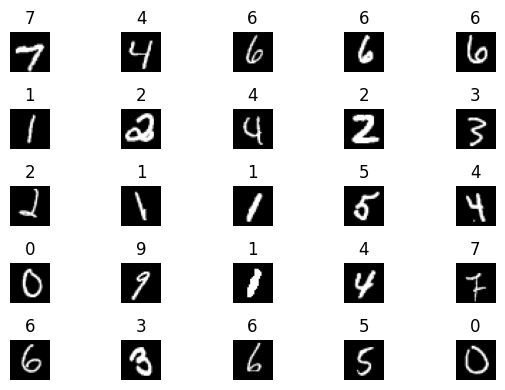

In [3]:
import matplotlib.pyplot as plt
import random

fig = plt.figure(dpi=100)
for ix in range(25):
	ax = plt.subplot(5, 5, ix + 1)
	i = random.randint(0, len(X_train)-1)
	img, label = X_train[i], y_train[i]
	ax.imshow(img.reshape(28,28), cmap='gray')
	ax.set_title(label)
	ax.axis('off')
plt.tight_layout()
plt.show()

En nuestra primera iteración, haremos un clasificador binario sencillo que detecte sólo el número 3. Más adelante iremos complicando los requisitos, lo cual nos dará opción a generar diferentes versiones de nuestro dataset y así ver un ejemplo de las herramientas necesarias para ello. Además, nos quedaremos con una pequeña muestra para empezar con un dataset limitado.

In [4]:
import numpy as np

X_train_3 = X_train[y_train == '3'][:100]
X_train_no_3 = X_train[y_train != '3'][:100]

len(X_train_3), len(X_train_no_3)

(100, 100)

In [5]:
def plot_samples(X):
	fig = plt.figure(dpi=100)
	for ix in range(25):
		ax = plt.subplot(5, 5, ix + 1)
		i = random.randint(0, len(X)-1)
		img = X[i]
		ax.imshow(img.reshape(28,28), cmap='gray')
		ax.axis('off')
	plt.tight_layout()
	plt.show()

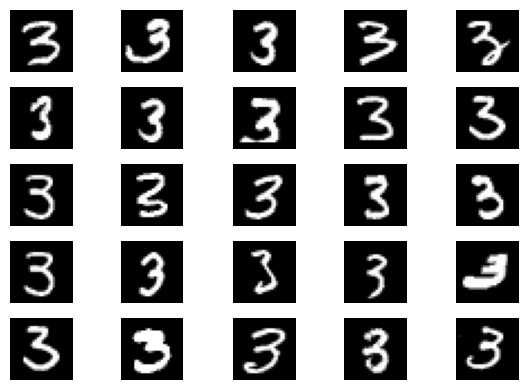

In [6]:
plot_samples(X_train_3)

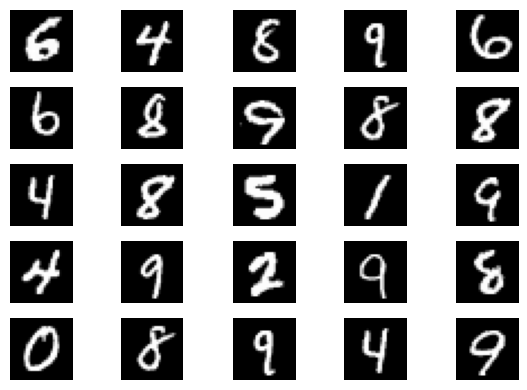

In [7]:
plot_samples(X_train_no_3)

Ahora guardaremos las imágenes en sendas carpetas, separando además un 20% de las muestras para el conjunto de test. A medida que nuestra aplicación vaya creciendo y siendo usada cada vez más deberemos identificar aquellos ejemplos en los que falla, etiquetarlo e incluirlos en el conjunto de test. Por otro lado, deberemos recoger ejemplos similares, etiquetarlos y añadirlos al conjunto de entrenamiento. De este manera, al re-entrenar los modelos, nos aseguraremos de ir corrigiendo errores de manera adecuada (este proceso se conoce como *active learning*).

In [8]:
import os 
from pathlib import Path
from skimage.io import imsave
import shutil

path = Path('./dataset')

def generate_dataset(X_train_3, X_train_no_3, test_size):
	if path.exists():
		shutil.rmtree(path)
	os.makedirs(path,493, exist_ok=True)

	splits = ['train', 'test']
	for split in splits:
		os.makedirs(path / split, exist_ok=True)
		os.makedirs(path / split / '3', exist_ok=True)
		os.makedirs(path / split / 'no3', exist_ok=True)
		if split == 'train':
			X1, X2 = X_train_3[:-test_size], X_train_no_3[:-test_size]
		else:
			X1, X2 = X_train_3[-test_size:], X_train_no_3[-test_size:]
		for x1, x2 in zip(X1, X2):
			imsave(path / split / '3' / f'{random.randint(0, 99999):05d}.png', x1.reshape(28,28).astype('uint8'))
			imsave(path / split / 'no3' / f'{random.randint(0, 99999):05d}.png', x2.reshape(28,28).astype('uint8'))


In [9]:
generate_dataset(X_train_3, X_train_no_3, 20)

In [11]:
from glob import glob

def get_paths():
	train_3 = glob(str(path / 'train' / '3' / '*.png'))
	train_no3 = glob(str(path / 'train' / 'no3' / '*.png'))
	test_3 = glob(str(path / 'test' / '3' / '*.png'))
	test_no3 = glob(str(path / 'test' / 'no3' / '*.png'))
	return train_3, train_no3, test_3, test_no3

train_3, train_no3, test_3, test_no3 = get_paths()

len(train_3), len(train_no3), len(test_3), len(test_no3)

(80, 80, 20, 20)

In [12]:
from skimage.io import imread 

def plot_images(paths):
	fig = plt.figure(dpi=100)
	for ix in range(25):
		ax = plt.subplot(5, 5, ix + 1)
		i = random.randint(0, len(paths)-1)
		img = imread(paths[i])
		ax.imshow(img, cmap='gray')
		ax.axis('off')
	plt.tight_layout()
	plt.show()

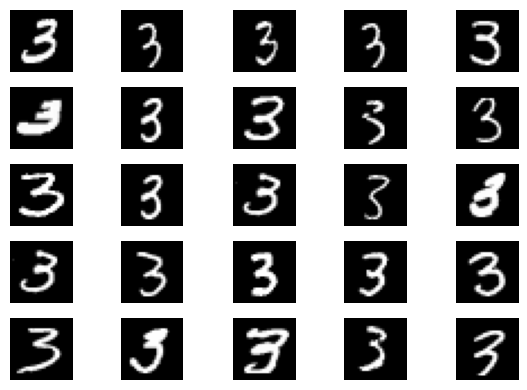

In [13]:
plot_images(train_3)

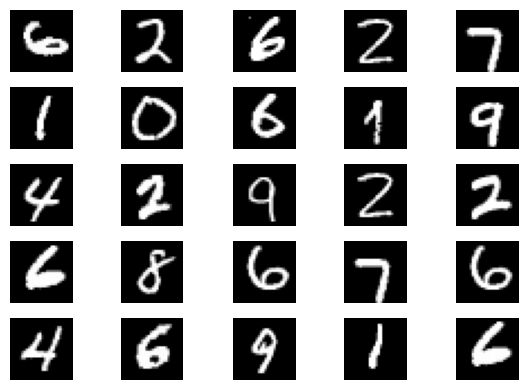

In [14]:
plot_images(train_no3)

## Versionado de datos

En este punto hemos generado una primera versión de nuestro dataset que queremos usar para entrenar nuestro primero modelo. Sabemos que en el futuro el dataset irá evolucionando, añadiendo más ejemplos y clases (y en función de la aplicación potencialmente nuevas tareas). La opción más sencilla para manejar esto sería generar un `.zip` con nuestros datos, ponerle un nombre (por ejemplo, mnist-v1.0) y guardarlo en algún servidor al cual puedan acceder los ingeniero de *deep learning* para entrenar modelos. Lo mismo podríamos hacer en el software 1.0 con nuestro código (y durante mucho tiempo así se hizo, incluso quizás hay empresas que aún lo hacen 😂) sin embargo hace tiempo que aprendimos que el uso de herramientas de `control de versión` son mucho más útiles y eficaces. El ejemplo principal es `git`. Así pues, para manejar nuestros datos (y más adelante modelos, métricas e incluso `pipelines` de entrenamiento) usaremos una herramienta de `control de versión` específica para trabajar con grandes datos en entornos de *machine learning* conocida como [dvc](https://dvc.org/). `dvc` trabaja en conjunto con `git`, así que lo primero que necesitaremos será un repositorio de `git`, que puedes alojar en `Github`, para manejar el proyecto.

> En mi caso he creado este [repo](https://github.com/juansensio/dlops) que usaré durante toda la serie de posts.

Puedes instalar `dvc` con el siguiente comando:

```
pip install dvc
```

Acto seguido, inicializaremos un repositorio con el comando: 

```
dvc init
```

Deberás ejectuar el comando al mismo nivel que el de git, ya que `dvc` utiliza git para el control de version de los metadatos asociados a los datos (archivos grandes). Esto generará una carpeta `.dvc` y un archivo `.dvcignore` similar a git. Ahora podemos añadir la carpeta con los datos al repositorio con el comando

```
dvc add dataset
```

El siguiente paso será conectar `dvc` con un servicio de almacenamiento remoto en el que guardar nuestros datos. Puedes utilizar diferentes servicios, [aquí](https://dvc.org/features) tienes una lista. En este caso utilizaremos [firebase](https://firebase.google.com/), ya que más adelante usaremos otras características como la base de datos. Para que `dvc` pueda acceder al `bucket` necesitaremos configurar la variable de entorno `GOOGLE_APPLICATION_CREDENTIALS`, siguiendo la [documentación](https://cloud.google.com/docs/authentication/getting-started#command-line) o descargando las credenciales desde la consola de firebase. Una vez conectado, podremos sincronizar nuestro dataset con el comando:

```
dvc remote add -d storage gs://dvctest-1b3be.appspot.com
export GOOGLE_APPLICATION_CREDENTIALS=dvcTest_key.json    
```
dvc push
```

Ahora puedes probar a eliminar la carpeta `dataset` y para volver a recuperarla puedes ejecutar

```
dvc pull dataset.dvc
```

Usaremos `git` para crear una nueva versión con el comando

```
git tag -a v0 -m "version 0"
```

`git` guardará los archivos específicos de `dvc` del commit con el tag determinado.

```
git add .
git commit -m "primera versión"
git push
git push origin --tags
```

En este punto, cualquiera con acceso al repositorio de `git` y `dvc` (con las credenciales necesarias de `firebase`) podrá acceder al dataset y a todas sus versiones de manera sencilla y remota para usarlo para entrenar modelos o modificarlo y crear nuevas versiones.

```
dvc pull
```

## Creando nuevas versiones

Ahora vamos a generar una nueva versión del dataset con 100 muestras más de las que teníamos anteriormente.

In [15]:
X_train_3 = X_train[y_train == '3'][:200]
X_train_no_3 = X_train[y_train != '3'][:200]

len(X_train_3), len(X_train_no_3)

(200, 200)

In [16]:
generate_dataset(X_train_3, X_train_no_3, 40)

In [17]:
train_3, train_no3, test_3, test_no3 = get_paths()

len(train_3), len(train_no3), len(test_3), len(test_no3)

(160, 160, 40, 40)

Utilizaremos los comando vistos anteriormente para crear una nueva versión:

```
dvc add dataset
dvc push 
git add .
git commit -m 'nueva version'
git push
git tag -a v1 -m "version 1"
git push origin --tags
```

Ahora que tenemos diferentes versiones podemos ir cambiando entre ellas de la siguiente manera.

```
git checkout tags/v0
dvc pull
```

In [ ]:
# versión 0 con 80/20 split

train_3, train_no3, test_3, test_no3 = get_paths()

len(train_3), len(train_no3), len(test_3), len(test_no3)

(80, 80, 20, 20)

```
git checkout tags/v1
dvc pull
```

In [ ]:
# versión 1 con 160/40 split

train_3, train_no3, test_3, test_no3 = get_paths()

len(train_3), len(train_no3), len(test_3), len(test_no3)

(160, 160, 40, 40)

## Resumen

En este post hemos aprendido a usar la herramienta de control de versiones [`dvc`](https://dvc.org/), la cual hemos usado para versionar nuestro dataset pero que también usaremos más adelante para versionar modelos, métricas e incluso `pipelines` completas de entrenamiento muy útiles para automatización. En este ejemplo hemos visto como generar varias versiones de un dataset para clasificación binaria de dígitos manuscritos que usaremos de ahora en adelante a medida que vayamos introduciendo técnicas y herramientas de DLOps y el cual iremos modificando (y versionando), añadiendo más ejemplos y más clases.